Presenté par Ahmed Mohamed et Sofiene Fehri

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import cm
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
from scipy import signal
from scipy.fftpack import fft, fftshift
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
class gmv:
    
    def __init__(self, d=2, attr=[], num_classes=2): 
        self.d = d
        self.mu = None
        self.attributes = attr
        self.cov_matrix = np.zeros((d,d))
        self.num_classes = num_classes
        
    def reduce_size(self,data_type, num_classes):
        x = None
        if data_type == 'train':
            x = self.train_inputs
        elif data_type == 'test':
            x = self.test_inputs
        
        if (isinstance(num_classes, int) and num_classes > len(self.train_inputs)) or num_classes == 'max':
            num_classes = len(self.train_inputs)
            temp_x = x[self.classes[0]]
            for num_classes in range(1,num_classes):
                temp_x = pd.concat([temp_x, x[self.classes[c]]])
            x = temp_x
     
        if len(self.attributes)>0:
            t = x
            col_names = list(x.columns.values)
            if isinstance(self.attributes[0], str):
                for c in col_names :
                    if c not in self.attributes:
                        t = t.drop(c,axis=1)
            elif isinstance(self.attributes[0], int):
                for c in self.attributes[1:]:
                    t = pd.concat([t, x[col_names[c]]])
                
            x = t
            
        else:
            x = np.resize(x,(len(x),self.d))
        
        return x
                
        
    def gmv_train(self,train_inputs):
        self.train_inputs = train_inputs
        self.classes = self.train_inputs['class'].unique() 
        if self.d < np.size(self.train_inputs,axis=1) or len(self.attributes)>0:
            self.train_inputs = self.reduce_size('train',self.num_classes)
        self.mu = np.mean(self.train_inputs,axis=0)
        self.sigma = np.diag(np.var(self.train_inputs,axis=0))
        pdf = multivariate_normal.pdf(self.train_inputs, self.mu, self.sigma)
        
        return pdf
    
    def gmv_predict(self,test_inputs, reduce = True):
        self.test_inputs = test_inputs
        if (self.d < np.size(self.train_inputs,axis=1) or len(self.attributes)>0) and reduce:
                self.test_inputs = self.reduce_size('test',self.num_classes) 
        return multivariate_normal.pdf(self.test_inputs,self.mu,self.sigma)
    
    

In [3]:
def load_data(percent):
    
    iris_df = pd.read_csv('iris.txt', names=['sepal_len','sepal_wid','petal_len','petal wid','class'])
    iris_df = shuffle(iris_df)
    classes = iris_df['class'].unique()
    
    ind = int(percent*len(iris_df))
    train_data = iris_df[:ind]
    test_data = iris_df[ind:]
    df_train = train_data[iris_df['class'] == classes[0]]
    df_test = test_data[iris_df['class'] == classes[0]]
        
    for c in classes[1:]:
        df_train = pd.concat([df_train, train_data[iris_df ['class'] == c]])
        df_test = pd.concat([df_test, test_data[iris_df['class'] == c]])
    return df_train,df_test

In [4]:
def gmv_plot(func):
    ### Gaussian 1D plot ####
    names = func.train_inputs.columns.values
    if (len(names) == 1):
        y = np.arange(min(func.train_inputs[names[0]]),max(func.test_inputs[names[0]]),0.1)
        t = func.gmv_predict(y,False)
        x = func.train_inputs
        plt.xlabel = "Train Inputs"
        plt.ylabel = "PDF (fonction de densité)"
        plt.plot(x,np.zeros((x.shape)),   marker ="o",        markersize = 5)
        plt.plot(y,t)
    
    #### Gaussian 2D plot ###
    elif (len(names) == 2):
        x = np.arange(3.6,8.2,0.1)
        y = np.arange(1.95,4.25,0.1)
        x, y = np.meshgrid(x, y)

        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x
        pos[:, :, 1] = y

        z = func.gmv_predict(pos,False)
        print(z.shape)
        fig = plt.figure()
        fig1 = plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=1, antialiased=True,
                        cmap=cm.viridis)
        
        cset = ax.contourf(x, y, z, zdir='z', offset=-0.15, cmap=cm.viridis, antialiased=True)
        plt.figure(figsize=(6,6))
        plt.contourf(x,y,z, zdir='z')
        ax.set_zlim(-0.15,0.4)
        ax.set_zticks(np.linspace(0,0.4,5))
        ax.view_init(27, -21)
        
    plt.show()


In [5]:
def gmv_classify(sample_df,d=2, data_type ='test'):
    x = sample_df
    prob, label, flower = [], [], [] 
    d = int(min(d,x.shape[1]))
    y = x.iloc[:,-1]
    x = x.iloc[:,:d]
    x = pd.concat([x, y], axis=1, join='inner')
    classes = x['class'].unique() 

    for i in range(len(classes)):
        cond = x['class'] == classes[i]
        mean = np.mean(x[cond].iloc[:,0:d].values, axis = 0)
        cov = np.cov(np.transpose(x[cond].iloc[:,0:d].values))
        func = multivariate_normal(mean =mean, cov=cov)
        prob.append(func.logpdf(x.iloc[:,0:d]))
        
    max_prob = np.argmax(prob, axis = 0)
    tf_number_error = [classes[i] != j for i,j in zip(max_prob, x['class'])]
    error_percent = str(100*np.sum(tf_number_error)/len(x)) + " %"
    prob = np.matrix(prob)
    
    for i,j in zip(max_prob, x['class']):
        flower.append(j)
        label.append(classes[i])
    if data_type == 'test':
        print("Classification error",error_percent,"\n")
    
    return [flower,label]

In [6]:
def gmv_classification_train(df_train,d,data_type):
    [flower, label] = gmv_classify(df_train,d,data_type)

In [7]:
def gmv_classification_test(df_test,d):
    [flower, label] = gmv_classify(df_test,d)
    error_df1 = pd.DataFrame({'prediction': label, 'flower': flower})
    return error_df1,flower

In [8]:
class parzen:
    def __init__(self, d, sigma, attr=[], num_classes=2):
        self.d = d
        self.sigma = sigma
        self.attributes = attr
        self.num_classes = num_classes
                    
    def train(self, train_inputs):
        self.train_inputs = train_inputs
        self.classes = self.train_inputs['class'].unique() 
        if self.d < np.size(self.train_inputs,axis=1) or len(self.attributes)>0:
            self.train_inputs = self.reduce_size('train',self.num_classes)
            
    def compute_prediction(self, test_inputs, reduce = True):
        sigma = self.sigma
        self.test_inputs = test_inputs
        d = self.d
        n = test_inputs.shape
        p = np.zeros(n)
        row_idx, col_idx = 0, 0
        
        if reduce:
            if (self.d < self.test_inputs.shape[1] or len(self.attributes)>0) :
                self.test_inputs = self.reduce_size('test',self.num_classes) 
                col_names =  list(self.test_inputs.columns.values)
                for i in col_names:
                    for test in self.test_inputs[i]:
                        distance = 0
                        for train in self.train_inputs[i]:
                            distance += np.exp(-(np.linalg.norm(test-train))**2 / (2.0 * self.sigma**2))
                            density = distance/((2*np.pi)**(d/2))*sigma**d
                            log_density = -np.log(density/len(self.train_inputs))
                        p[row_idx][col_idx] = log_density
                        row_idx += 1
                    row_idx = 0
                    col_idx += 1
                    
        elif self.d > 1:
            distance += np.exp(-(np.linalg.norm(test_inputs[0]-test_inputs[1]))**2 / (2.0 * self.sigma**2))
            density = distance/((2*np.pi)**(d/2))*sigma**d
            log_density = -np.log(density/len(self.train_inputs))
            p[i][j] = log_density
        else:
            p = test_inputs
        
        return p
    
    def reduce_size(self,data_type, num_classes):
        x = None
        if data_type == 'train':
            x = self.train_inputs
        elif data_type == 'test':
            x = self.test_inputs
        
        if (isinstance(num_classes, int) and num_classes > len(self.train_inputs)) or num_classes == 'max':
            num_classes = len(self.train_inputs)
            temp_x = x[self.classes[0]]
            for num_classes in range(1,num_classes):
                temp_x = pd.concat([temp_x, x[self.classes[c]]])
            x = temp_x
     
        if len(self.attributes)>0:
            t = x
            col_names = list(x.columns.values)
            if isinstance(self.attributes[0], str):
                for c in col_names :
                    if c not in self.attributes:
                        t = t.drop(c,axis=1)
            elif isinstance(self.attributes[0], int):
                for c in self.attributes[1:]:
                    t = pd.concat([t, x[col_names[c]]])
                
            x = t
            
        else:
            cols = list(x.columns.values)
            for i in range(len(cols)):
                if i > self.d:
                    x = x.drop(cols[i],axis=1)
        
        return x

In [9]:
def parzen_plot(func):
    ### Gaussian 1D plot ####
    names = func.train_inputs.columns.values
    print(names)
    if (len(names) == 1):
        y = np.arange(min(func.train_inputs[names[0]]),max(func.test_inputs[names[0]]),0.1)
        t = func.compute_prediction(y,False)
        x = func.train_inputs
        plt.xlabel = "Train Inputs"
        plt.ylabel = "PDF (fonction de densité)"
        plt.plot(x,np.zeros((x.shape)),   marker ="o",        markersize = 5)
        plt.plot(y,t)
    
    #### Gaussian 2D plot ###
    elif (len(names) == 2):
        x = np.arange(3.6,8.2,0.1)
        y = np.arange(1.95,4.25,0.1)
        x, y = np.meshgrid(x, y)

        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x
        pos[:, :, 1] = y

        z = func.compute_prediction(pos,False)
        print(z)
        fig = plt.figure()
        fig1 = plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=1, antialiased=True,
                        cmap=cm.viridis)
        
        cset = ax.contourf(x, y, z, zdir='z', offset=-0.15, cmap=cm.viridis, antialiased=True)
        plt.figure(figsize=(6,6))
        plt.contourf(x,y,z, zdir='z')
        ax.set_zlim(-0.15,0.4)
        ax.set_zticks(np.linspace(0,0.4,5))
        ax.view_init(27, -21)
        
    plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


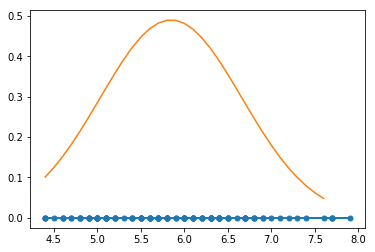

(23, 46)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'zdir'
  s)


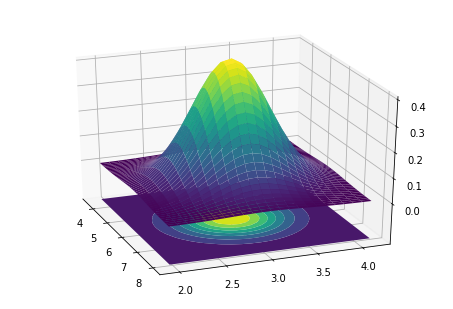

<Figure size 432x288 with 0 Axes>

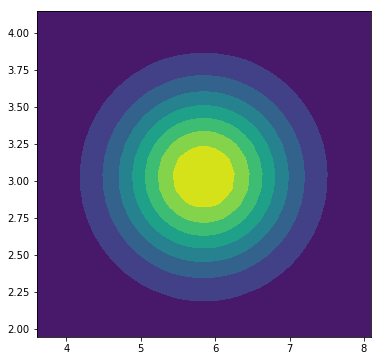

Classification error 0.0 % 

         prediction           flower
0    Iris-virginica   Iris-virginica
1    Iris-virginica   Iris-virginica
2    Iris-virginica   Iris-virginica
3    Iris-virginica   Iris-virginica
4    Iris-virginica   Iris-virginica
5    Iris-virginica   Iris-virginica
6    Iris-virginica   Iris-virginica
7    Iris-virginica   Iris-virginica
8    Iris-virginica   Iris-virginica
9    Iris-virginica   Iris-virginica
10   Iris-virginica   Iris-virginica
11  Iris-versicolor  Iris-versicolor
12  Iris-versicolor  Iris-versicolor
13  Iris-versicolor  Iris-versicolor
14  Iris-versicolor  Iris-versicolor
15  Iris-versicolor  Iris-versicolor
16  Iris-versicolor  Iris-versicolor
17  Iris-versicolor  Iris-versicolor
18      Iris-setosa      Iris-setosa
19      Iris-setosa      Iris-setosa
20      Iris-setosa      Iris-setosa
21      Iris-setosa      Iris-setosa
22      Iris-setosa      Iris-setosa
23      Iris-setosa      Iris-setosa
24      Iris-setosa      Iris-setosa
25      I

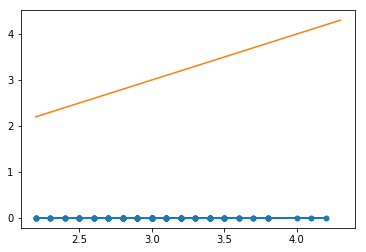

['sepal_wid']


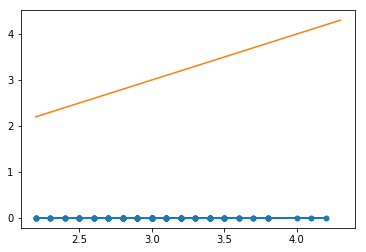

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: divide by zero encountered in log


['sepal_wid']


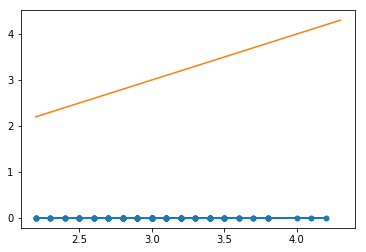

['sepal_len' 'sepal_wid']


UnboundLocalError: local variable 'distance' referenced before assignment

In [10]:
def main():
    train_inputs,test_inputs = load_data(0.8)
    names = ['sepal_len','sepal_wid']
    
    gaussian = gmv(1,['sepal_len'],1)
    gaussian.gmv_train(train_inputs)
    gaussian.gmv_predict(test_inputs)
    gmv_plot(gaussian)
    
    gaussian = gmv(2,[x for x in names],2)
    gaussian.gmv_train(train_inputs)
    gaussian.gmv_predict(test_inputs)
    gmv_plot(gaussian)
    
    df_train,df_test = load_data(0.8)
    gmv_classification_train(df_train,4,'train')
    error_df1,flower = gmv_classification_test(df_test,4)
    print(error_df1.head(n=len(flower)))
    
    parz = parzen(1,100,['sepal_wid'])
    parz.train(train_inputs)
    parz_pred = parz.compute_prediction(test_inputs)
    parzen_plot(parz)
    
    parz1 = parzen(1,1,['sepal_wid'])
    parz1.train(train_inputs)
    parz1_pred = parz1.compute_prediction(test_inputs)
    parzen_plot(parz1)
    
    parz2 = parzen(1,0.01,['sepal_wid'])
    parz2.train(train_inputs)
    parz2_pred = parz2.compute_prediction(test_inputs)
    parzen_plot(parz2)
    
    parz3 = parzen(2,2,['sepal_len','sepal_wid'])
    parz3.train(train_inputs)
    parz3_pred = parz3.compute_prediction(test_inputs)
    parzen_plot(parz3)
    
main()